


# Skip-gram word2vec

使用TensorFlow来实现使用skip-gram架构的word2vec算法。 通过实现这一点，您将学习嵌入用于自然语言处理的单词。 当处理机器翻译等事情时，这将会派上用场。

## 阅读

以下是我用来构建这款笔记本的资源。 我建议您提前阅读这些内容，或者正在使用此材料。

*来自Chris McCormick的word2vec的一个非常好的[概念概述]（http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/ ）
*来自Mikolov等人的[First word2vec paper]（https://arxiv.org/pdf/1301.3781.pdf ）
* [NIPS论文]（http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf ），还有来自Mikolov等人对word2vec的改进。
*来自Thushan Ganegedara的[实施word2vec]（http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/ ）
* TensorFlow [word2vec tutorial]（https://www.tensorflow.org/tutorials/word2vec ）


## 字嵌入

当你在处理文本中的单词时，最终会有数以万计的类来预测，每个单词都是一个。尝试对这些单词进行一次热编码是非常低效的，您将一个元素设置为1，另一个元素设置为0.进入第一个隐藏层的矩阵乘法将几乎所有结果值都为零。这是一个巨大的浪费计算。

![one-hot encodings](assets/one_hot_encoding.png)

为了解决这个问题，大大提高了网络的效率，我们使用了所谓的嵌入。嵌入式操作只是一个完全连接的层，就像您之前看过的那样。我们称这个层为嵌入层，权重为嵌入权重。我们通过相反直接从权重矩阵中获取隐藏层值来跳过嵌入层的乘法。我们可以做到这一点，因为单热编码向量与矩阵的乘法返回对应于“开”输入单元的索引的矩阵行。

![lookup](assets/lookup_matrix.png)

而不是进行矩阵乘法，我们使用权重矩阵作为查找表。我们将单词作为整数进行编码，例如“heart”被编码为958，“mind”为18094.然后为了获取“heart”的隐藏层值，您只需要嵌入矩阵的第958行。这个过程称为**嵌入查询**，隐藏单位数是**嵌入维度**。

<img src='assets/tokenize_lookup.png' width=500>
 
这里没有什么神奇的东西。嵌入查找表只是一个权重矩阵。嵌入层只是一个隐藏层。查找只是矩阵乘法的一个快捷方式。查找表也像任何权重矩阵一样被训练。

当然，嵌入不仅用于词语。您可以将它们用于您拥有大量课程的任何模型。称为** Word2Vec **的特定类型的模型使用嵌入层来查找包含语义含义的单词的向量表示。


## Word2Vec

word2vec算法通过查找表示单词的向量来找到更有效的表示。 这些向量还包含有关单词的语义信息。 在类似的上下文中出现的单词（例如“黑色”，“白色”和“红色”）将具有彼此靠近的向量。 有两种实现word2vec，CBOW（Continuous Bag-Of-Words）和Skip-gram的架构。

<img src="assets/word2vec_architectures.png" width="500">

在这个实现中，我们将使用skip-gram架构，因为它比CBOW更好。 在这里，我们通过一个字，并尝试预测文本中的单词。 以这种方式，我们可以训练网络来学习在类似语境中显示的单词的表示。

首先，导入包。

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils


加载[text8 dataset]（http://mattmahoney.net/dc/textdata.html ），从Matt Mahoney清理维基百科文章的文件。 下一个单元格将数据集下载到`data`文件夹。 然后，您可以提取它并删除存档文件以节省存储空间。

In [9]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()


## 预处理

在这里我正在修改文本，使培训更加容易。 这来自我写的`utils`模块。 “预处理”功能将任何标点符号覆盖到令牌中，因此一段时间更改为“<PERIOD>”。 在这个数据集中，没有任何期间，但它将有助于其他NLP问题。 我也删除在数据集中显示五次或更少次的所有单词。 这将大大减少由于数据中的噪声引起的问题，并提高了矢量表示的质量。 如果你想为这个东西编写你自己的功能，那就去吧。

In [10]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [11]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641




在这里，我创建了将单词转换为整数和向后的整数字词。 整数以降序分配，所以最常用的单词（“the”）被赋予整数0，下一个最常用的是1，依此类推。 这些单词被转换为整数，并存储在列表int_words中。

In [12]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]


## 采样

经常出现的词语，如“，”和“for”不会给附近的单词提供很多的上下文。如果我们丢弃其中的一些，我们可以从我们的数据中删除一些噪音，并返回获得更快的训练和更好的表示。这个过程称为Mikolov的二次抽样。对于训练集中的每个单词$ w_i $，我们将以概率给出舍弃它

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$ t $是阈值参数，$ f（w_i）$是总数据集中单词$ w_i $的频率。

我要把这个放在你的身上。这更像是编程挑战，而不是专门深入学习。但是，能够为您的网络准备数据是一个重要的技能。看看我的解决方案，看看我是怎么做到的。

> **练习：**对“int_words”中的单词进行子抽样。也就是说，通过`int_words`并丢弃给出上述可能性$ P（w_i）$的每个单词。请注意，$ P（w_i）$是丢弃字词的概率。将子采样数据分配给“train_words”。

In [18]:
from collections import Counter
import random

threshoud = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word:count/total_count for word,count in word_counts.items()}
p_drop = {word:1-np.sqrt(threshoud/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random()<(1-p_drop[word])]

In [21]:
print(train_words[0:30])


[5237, 3082, 3134, 476, 10607, 133, 27706, 15083, 61169, 3580, 190, 58, 10762, 2731, 3674, 708, 26, 540, 2757, 7096, 5237, 1052, 248, 44672, 2880, 602, 1135, 8986, 4156, 6439]




##  制作批次
现在我们的数据状况良好，我们需要将其转化为正确的形式，将其传递到我们的网络中。 使用skip-gram架构，对于文本中的每个单词，我们要抓住该单词的窗口中的所有单词，大小为$C$。

来自[Mikolov等人]（https://arxiv.org/pdf/1301.3781.pdf ）：

“由于较远的单词通常与现在的单词相比较接近，所以我们通过在训练示例中对这些单词进行抽样较少，对较远的单词给予较少的重量。如果我们选择$C = 5$， 对于每个训练单词，我们将随机选择$ $ 1; C> $中的$R$，然后使用来自历史记录的$R$词和来自当前单词的未来的$R$单词作为正确的标签。

> **练习：**实现一个函数“get_target”，它接收单词列表，索引和窗口大小，然后在索引周围的窗口中返回一个单词列表。 请确保使用上述算法，您可以从窗口中选择随机数字。

In [41]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


这是一个为我们的网络返回批次的功能。 这个想法是从单词列表中获取“batch_size”的单词。 然后对于这些单词，它会在窗口中获取目标单词。 我没有找到一种方法来传递一个随机数的目标单词，并让它使用架构，所以我每输入一个目标对一行。 这是一种发电机功能的方式，有助于节省内存。

In [24]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    


## 建立图表

从[Chris McCormick的博客]（http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model /），我们可以看到我们网络的一般结构。
![embedding_network](./assets/skip_gram_net_arch.png)

输入字作为整数传入。这将进入隐藏的线性单位层，然后进入softmax层。我们将使用softmax层进行像正常的预测。

这里的想法是训练隐层重量矩阵，以找到我们的话的有效表示。我们可以丢弃softmax层，因为我们不太在乎用这个网络进行预测。我们只想要嵌入矩阵，所以我们可以在数据集构建的其他网络中使用它。

我现在要分阶段构建图表。首先，创建“input”和“label”占位符，如正常。

> **练习：**使用`tf.placeholder`指定`inputs`和`labels`。我们要传入整数，所以将数据类型设置为`tf.int32`。我们传递的批次将具有不同的大小，因此将批量大小设置为[`无]。为了使事情稍后工作，您需要将“labels”的第二个维度设置为“None”或“1”。

In [26]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding





嵌入矩阵具有隐藏层中单位数的字数。所以，如果你有10,000个单词和300个隐藏的单位，那么矩阵的大小为$ 10,000 \ times 300 $。请记住，我们使用令牌化数据作为输入，通常为整数，令牌数是我们词汇表中单词数量。


> **练习：** Tensorflow为我们提供了一个方便的函数[`tf.nn.embedding_lookup`]（https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup ）。您传入嵌入矩阵和一个整数的张量，然后返回与这些整数对应的矩阵中的行。下面，设置您将使用的嵌入功能的数量（200是一个好的开始），创建嵌入矩阵变量，并使用`tf.nn.embedding_lookup`获取嵌入张量。对于嵌入矩阵，我建议您使用[tf.random_uniform]（https://www.tensorflow.org/api_docs/python/tf/random_uniform ）以-1和1之间的均匀随机数初始化它。

In [27]:
n_vocab = len(int_to_vocab)
n_embedding =200  # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab,n_embedding),-1,1))# create embedding weight matrix here
    embed =tf.nn.embedding_lookup(embedding,inputs) # use tf.nn.embedding_lookup to get the hidden layer output




## 负采样
对于我们给网络的每个例子，我们使用softmax层的输出进行训练。这意味着对于每个输入，我们正在对数百万的权重进行非常小的更改，即使我们只有一个真实的例子。这使得培训网络非常低效。我们可以通过仅一次更新所有权重的一小部分来近似来自softmax层的损失。我们将更新正确标签的权重，但只会更改少量不正确的标签。这被称为[“负抽样”]（http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf ）。 Tensorflow有一个方便的功能来做到这一点，[`tf.nn.sampled_softmax_loss`]（https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss ）。

> **练习：**下面，为softmax层创建权重和偏差。然后，使用[`tf.nn.sampled_softmax_loss`]（https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss ）来计算损失。请务必阅读文档，了解它的工作原理。

In [29]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)


## 验证

这段代码来自于Thushan Ganegedara的实现。 在这里，我们要选择一些常用的单词和几个不常见的单词。 然后，我们将打印出最接近他们的单词。 这是一个很好的方式来检查我们的嵌入表是否将具有相似语义含义的单词分组在一起。

In [30]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [31]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

## Training

以下是训练网络的代码。 每100批次报告训练损失。 每1000批次，它将打印验证字。

In [42]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.7074 0.3563 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6314 0.3535 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.4912 0.3390 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.6369 0.3418 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5324 0.3457 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5399 0.3639 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5401 0.3385 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5638 0.3379 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4621 0.3436 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4434 0.3402 sec/batch
Nearest to be: roofed, prevail, muscovites, swarm, industrially, antiquark, laika, transfer,
Nearest to is: plunging, freebase, hara, frottage, longest, disbelief, cries, boleyn,
Nearest to i: coefficient, shortens, biblioteca, chopsticks, wholesale, vegetable, mammalia, hilda,
Nearest to state: ha

Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6723 0.3181 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6687 0.3083 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6164 0.3107 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6419 0.3137 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6379 0.3115 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6220 0.3092 sec/batch
Epoch 2/10 Iteration: 4700 Avg. Training loss: 4.5950 0.2231 sec/batch
Epoch 2/10 Iteration: 4800 Avg. Training loss: 4.5542 0.3126 sec/batch
Epoch 2/10 Iteration: 4900 Avg. Training loss: 4.4994 0.3115 sec/batch
Epoch 2/10 Iteration: 5000 Avg. Training loss: 4.5059 0.3154 sec/batch
Nearest to be: industrially, vendor, correlated, transfer, velocities, swarm, roofed, perform,
Nearest to is: cries, routine, of, freebase, fulda, disbelief, herz, on,
Nearest to i: coefficient, biblioteca, wholesale, roses, questions, ali, ferrer, katrina,
Nearest to state: yy, haydn, nev

Epoch 2/10 Iteration: 8100 Avg. Training loss: 4.3221 0.3167 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 4.2965 0.3134 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 4.3852 0.3127 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 4.3812 0.3096 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 4.3826 0.3114 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 4.2984 0.3139 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 4.3120 0.3115 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 4.3232 0.3135 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 4.2133 0.3116 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 4.2788 0.3104 sec/batch
Nearest to be: correlated, qwerty, aps, swarm, industrially, hard, a, prevail,
Nearest to is: of, li, cries, fulda, herz, x, cones, bryan,
Nearest to i: biblioteca, questions, t, know, coefficient, cont, drover, chaos,
Nearest to state: yy, nevada, falls, prokaryote, bonifacio, hieroglyph,

Epoch 3/10 Iteration: 12100 Avg. Training loss: 4.2001 0.3246 sec/batch
Epoch 3/10 Iteration: 12200 Avg. Training loss: 4.1378 0.3144 sec/batch
Epoch 3/10 Iteration: 12300 Avg. Training loss: 4.1785 0.3107 sec/batch
Epoch 3/10 Iteration: 12400 Avg. Training loss: 4.1735 0.3095 sec/batch
Epoch 3/10 Iteration: 12500 Avg. Training loss: 4.1549 0.3151 sec/batch
Epoch 3/10 Iteration: 12600 Avg. Training loss: 4.1527 0.3134 sec/batch
Epoch 3/10 Iteration: 12700 Avg. Training loss: 4.1865 0.3181 sec/batch
Epoch 3/10 Iteration: 12800 Avg. Training loss: 4.1198 0.3175 sec/batch
Epoch 3/10 Iteration: 12900 Avg. Training loss: 4.1861 0.3189 sec/batch
Epoch 3/10 Iteration: 13000 Avg. Training loss: 4.1943 0.3166 sec/batch
Nearest to be: aps, prevail, execute, bowels, correlated, a, qwerty, hard,
Nearest to is: of, mutinous, cries, li, k, fulda, bryan, on,
Nearest to i: biblioteca, t, me, questions, you, know, ferrer, drover,
Nearest to state: yy, nevada, falls, confirmed, states, excommunication, 

Epoch 4/10 Iteration: 16100 Avg. Training loss: 4.0742 0.3223 sec/batch
Epoch 4/10 Iteration: 16200 Avg. Training loss: 4.1023 0.3102 sec/batch
Epoch 4/10 Iteration: 16300 Avg. Training loss: 4.0642 0.3081 sec/batch
Epoch 4/10 Iteration: 16400 Avg. Training loss: 4.0676 0.3086 sec/batch
Epoch 4/10 Iteration: 16500 Avg. Training loss: 4.0766 0.3151 sec/batch
Epoch 4/10 Iteration: 16600 Avg. Training loss: 4.0306 0.3153 sec/batch
Epoch 4/10 Iteration: 16700 Avg. Training loss: 4.0656 0.3103 sec/batch
Epoch 4/10 Iteration: 16800 Avg. Training loss: 4.0379 0.3088 sec/batch
Epoch 4/10 Iteration: 16900 Avg. Training loss: 4.0815 0.3129 sec/batch
Epoch 4/10 Iteration: 17000 Avg. Training loss: 4.0797 0.3143 sec/batch
Nearest to be: aps, execute, prevail, a, all, perform, hyperplane, anathema,
Nearest to is: of, li, mutinous, cries, holomorphic, essences, bryan, k,
Nearest to i: t, me, biblioteca, you, questions, know, ferrer, n,
Nearest to state: yy, nevada, falls, confirmed, bonifacio, state

Epoch 5/10 Iteration: 20100 Avg. Training loss: 3.9699 0.3101 sec/batch
Epoch 5/10 Iteration: 20200 Avg. Training loss: 3.9983 0.3039 sec/batch
Epoch 5/10 Iteration: 20300 Avg. Training loss: 3.9662 0.3040 sec/batch
Epoch 5/10 Iteration: 20400 Avg. Training loss: 4.0384 0.3039 sec/batch
Epoch 5/10 Iteration: 20500 Avg. Training loss: 4.0448 0.3040 sec/batch
Epoch 5/10 Iteration: 20600 Avg. Training loss: 3.9837 0.3048 sec/batch
Epoch 5/10 Iteration: 20700 Avg. Training loss: 3.9708 0.3058 sec/batch
Epoch 5/10 Iteration: 20800 Avg. Training loss: 4.0204 0.3056 sec/batch
Epoch 5/10 Iteration: 20900 Avg. Training loss: 4.0018 0.3054 sec/batch
Epoch 5/10 Iteration: 21000 Avg. Training loss: 3.9989 0.3066 sec/batch
Nearest to be: execute, all, prevail, nitrates, hyperplane, a, aps, those,
Nearest to is: of, the, according, mutinous, on, li, extensionality, as,
Nearest to i: t, me, you, questions, biblioteca, know, n, my,
Nearest to state: yy, nevada, falls, bonifacio, confirmed, states, kan

Epoch 6/10 Iteration: 24100 Avg. Training loss: 3.9649 0.3112 sec/batch
Epoch 6/10 Iteration: 24200 Avg. Training loss: 3.9862 0.3052 sec/batch
Epoch 6/10 Iteration: 24300 Avg. Training loss: 3.8835 0.3038 sec/batch
Epoch 6/10 Iteration: 24400 Avg. Training loss: 3.9309 0.3039 sec/batch
Epoch 6/10 Iteration: 24500 Avg. Training loss: 3.9064 0.3013 sec/batch
Epoch 6/10 Iteration: 24600 Avg. Training loss: 3.8820 0.3034 sec/batch
Epoch 6/10 Iteration: 24700 Avg. Training loss: 3.9215 0.3028 sec/batch
Epoch 6/10 Iteration: 24800 Avg. Training loss: 3.9601 0.3033 sec/batch
Epoch 6/10 Iteration: 24900 Avg. Training loss: 3.9096 0.3035 sec/batch
Epoch 6/10 Iteration: 25000 Avg. Training loss: 3.9271 0.3036 sec/batch
Nearest to be: hyperplane, all, a, nitrates, larvae, thermotropic, prevail, aps,
Nearest to is: of, the, as, according, extensionality, or, on, not,
Nearest to i: me, t, you, questions, know, my, n, am,
Nearest to state: yy, nevada, falls, bonifacio, states, kansas, pw, leicester

Epoch 7/10 Iteration: 28100 Avg. Training loss: 3.8886 0.3612 sec/batch
Epoch 7/10 Iteration: 28200 Avg. Training loss: 3.9188 0.3483 sec/batch
Epoch 7/10 Iteration: 28300 Avg. Training loss: 3.8861 0.3435 sec/batch
Epoch 7/10 Iteration: 28400 Avg. Training loss: 3.9039 0.3475 sec/batch
Epoch 7/10 Iteration: 28500 Avg. Training loss: 3.8437 0.3287 sec/batch
Epoch 7/10 Iteration: 28600 Avg. Training loss: 3.9184 0.3059 sec/batch
Epoch 7/10 Iteration: 28700 Avg. Training loss: 3.8762 0.3060 sec/batch
Epoch 7/10 Iteration: 28800 Avg. Training loss: 3.9624 0.3028 sec/batch
Epoch 7/10 Iteration: 28900 Avg. Training loss: 3.8362 0.3118 sec/batch
Epoch 7/10 Iteration: 29000 Avg. Training loss: 3.8714 0.3243 sec/batch
Nearest to be: all, larvae, would, nitrates, hyperplane, a, execute, cycorp,
Nearest to is: of, the, according, has, or, are, as, either,
Nearest to i: me, t, you, telegram, questions, know, am, my,
Nearest to state: nevada, yy, states, bonifacio, falls, pw, governors, acceptabil

Epoch 7/10 Iteration: 32300 Avg. Training loss: 3.9195 0.3243 sec/batch
Epoch 7/10 Iteration: 32400 Avg. Training loss: 3.9207 0.3074 sec/batch
Epoch 8/10 Iteration: 32500 Avg. Training loss: 3.9181 0.2960 sec/batch
Epoch 8/10 Iteration: 32600 Avg. Training loss: 3.8825 0.3315 sec/batch
Epoch 8/10 Iteration: 32700 Avg. Training loss: 3.8664 0.3176 sec/batch
Epoch 8/10 Iteration: 32800 Avg. Training loss: 3.8919 0.3082 sec/batch
Epoch 8/10 Iteration: 32900 Avg. Training loss: 3.8531 0.3243 sec/batch
Epoch 8/10 Iteration: 33000 Avg. Training loss: 3.8700 0.3493 sec/batch
Nearest to be: all, a, larvae, would, hyperplane, nitrates, assess, is,
Nearest to is: of, the, according, has, as, or, on, either,
Nearest to i: me, t, you, questions, telegram, know, my, isonzo,
Nearest to state: nevada, yy, states, falls, bonifacio, pw, kansas, missouri,
Nearest to when: a, dissolved, back, nor, that, jehoshaphat, burns, becomes,
Nearest to d: eusebio, one, josef, destabilized, b, sut, lussac, tallis,

Epoch 8/10 Iteration: 36600 Avg. Training loss: 3.8782 0.3109 sec/batch
Epoch 8/10 Iteration: 36700 Avg. Training loss: 3.8277 0.3163 sec/batch
Epoch 8/10 Iteration: 36800 Avg. Training loss: 3.9009 0.3117 sec/batch
Epoch 8/10 Iteration: 36900 Avg. Training loss: 3.9014 0.3102 sec/batch
Epoch 8/10 Iteration: 37000 Avg. Training loss: 3.8718 0.3073 sec/batch
Nearest to be: a, all, larvae, hyperplane, would, is, botulinum, celebratory,
Nearest to is: of, the, has, as, according, a, or, either,
Nearest to i: me, t, you, am, questions, know, telegram, glad,
Nearest to state: yy, states, nevada, bonifacio, missouri, pw, falls, kansas,
Nearest to when: a, back, dissolved, shortly, nor, that, jehoshaphat, becomes,
Nearest to d: eusebio, one, b, tallis, josef, bourque, destabilized, henri,
Nearest to five: four, six, three, one, two, zero, seven, nine,
Nearest to than: less, to, more, these, because, precision, rewriting, prescribes,
Nearest to know: pronounce, dairies, my, i, sorry, remember,

Epoch 9/10 Iteration: 40900 Avg. Training loss: 3.9066 0.3433 sec/batch
Epoch 9/10 Iteration: 41000 Avg. Training loss: 3.8137 0.3328 sec/batch
Nearest to be: a, all, is, hyperplane, that, consider, as, intension,
Nearest to is: of, the, or, has, according, as, a, are,
Nearest to i: me, t, you, know, questions, glad, telegram, my,
Nearest to state: states, yy, nevada, missouri, bonifacio, pw, leicestershire, falls,
Nearest to when: a, dissolved, back, that, nor, but, in, jehoshaphat,
Nearest to d: eusebio, destabilized, josef, tallis, nesbit, one, henri, thorstein,
Nearest to five: four, six, three, one, two, zero, seven, nine,
Nearest to than: less, to, because, more, these, five, smaller, prescribes,
Nearest to know: pronounce, my, i, remember, dairies, sorry, do, we,
Nearest to units: marines, nist, metre, kilometre, races, si, unit, large,
Nearest to gold: silver, coin, griese, bronze, hudson, gilberto, azeglio, cantona,
Nearest to discovered: discoveries, stronghold, philistine, v

Epoch 10/10 Iteration: 45100 Avg. Training loss: 3.8523 0.3342 sec/batch
Epoch 10/10 Iteration: 45200 Avg. Training loss: 3.8338 0.3261 sec/batch
Epoch 10/10 Iteration: 45300 Avg. Training loss: 3.8663 0.3096 sec/batch
Epoch 10/10 Iteration: 45400 Avg. Training loss: 3.9297 0.3091 sec/batch
Epoch 10/10 Iteration: 45500 Avg. Training loss: 3.8858 0.3046 sec/batch
Epoch 10/10 Iteration: 45600 Avg. Training loss: 3.8346 0.3071 sec/batch
Epoch 10/10 Iteration: 45700 Avg. Training loss: 3.7879 0.3053 sec/batch
Epoch 10/10 Iteration: 45800 Avg. Training loss: 3.8441 0.3048 sec/batch
Epoch 10/10 Iteration: 45900 Avg. Training loss: 3.7156 0.3058 sec/batch
Epoch 10/10 Iteration: 46000 Avg. Training loss: 3.8632 0.3093 sec/batch
Nearest to be: all, is, a, that, would, as, to, hyperplane,
Nearest to is: of, the, a, has, as, or, according, an,
Nearest to i: me, t, you, my, know, want, glad, ve,
Nearest to state: states, nevada, yy, missouri, is, bonifacio, governors, falls,
Nearest to when: a, di

如果需要，请恢复受过训练的网络：

In [43]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## 可视化字向量

下面我们将使用T-SNE可视化我们的高维度字矢量如何聚集在一起。 T-SNE用于将这些向量投影到两维中，同时保留局部结构。 查看[Christopher Olah的这篇文章]（http://colah.github.io/posts/2014-10-Visualizing-MNIST/ ）了解更多关于T-SNE和其他可视化高维数据的方法。

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [45]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

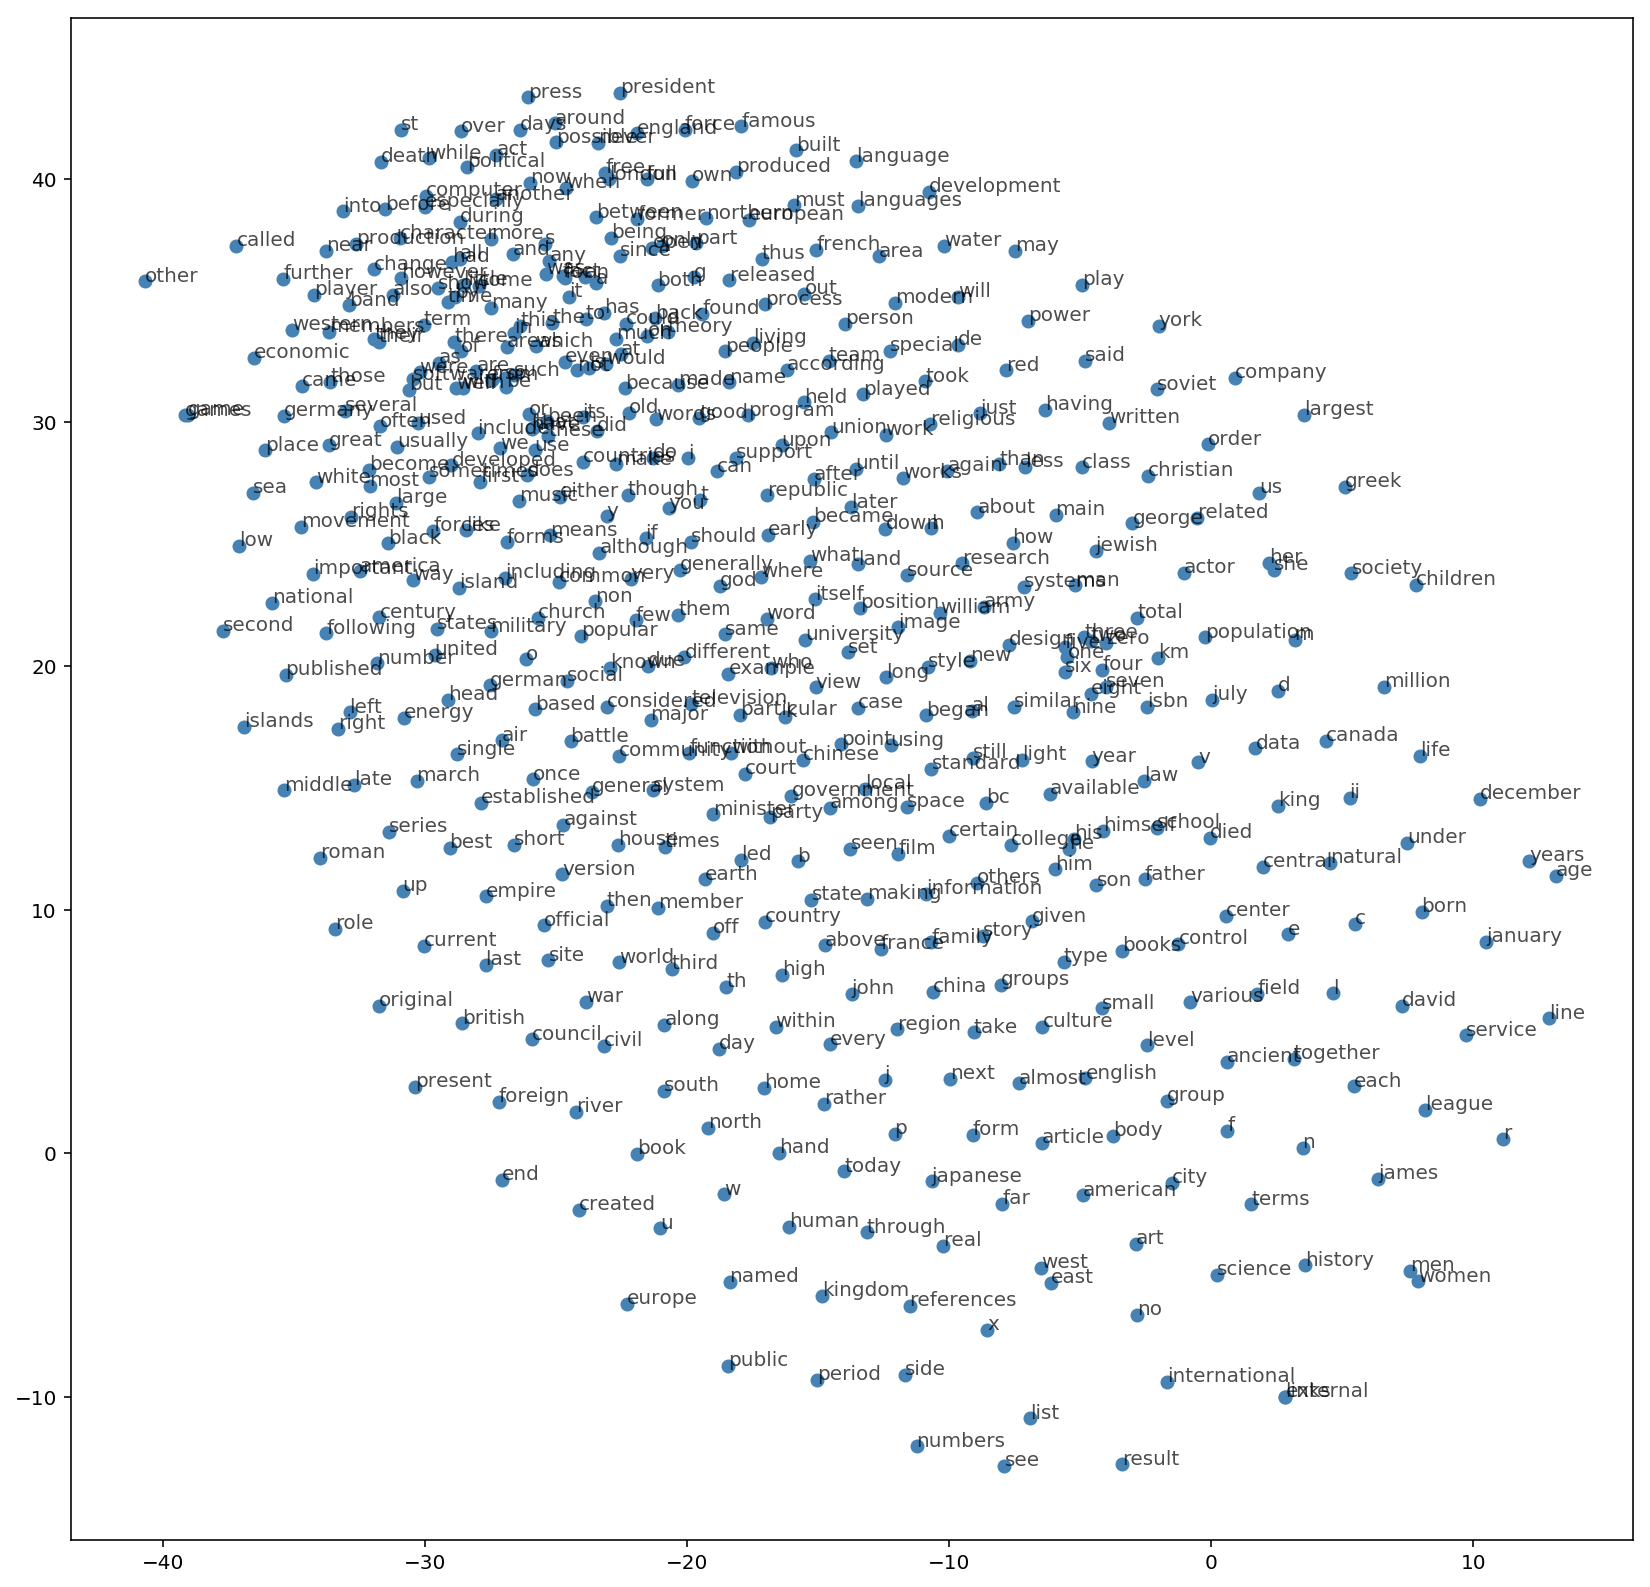

In [46]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)